In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface,
                                HeliocentricEarthEcliptic, get_body_heliographic_stonyhurst)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.time import Time
import eispac
import irispy.io
import pyvista as pv
import h5py
from scipy.interpolate import LinearNDInterpolator
from scipy.io import readsav
import ndcube

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize,PowerStretch)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   

/tmp/ipykernel_177929/4010631969.py:21: UserWarning: could not determine irispy package version; this indicates a broken installation
  import irispy.io


In [2]:
hri_174_map_shifted_toaia = sunpy.map.Map("../../src/coalign_map/20221024/hri_174_map_shifted_toaia.fits")

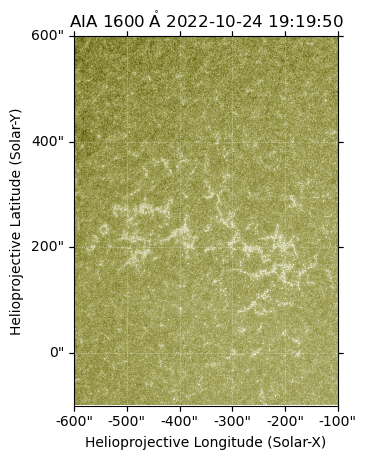

In [3]:
aia_1600_map = sunpy.map.Map("../../src/AIA/20221024/1600/lvl15/aia.lev1_uv_24s.2022-10-24T191951Z.1600.image.fits")
aia_1600_map_crop = aia_1600_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_1600_map.coordinate_frame), 
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_1600_map.coordinate_frame))
aia_1600_map_crop.plot()

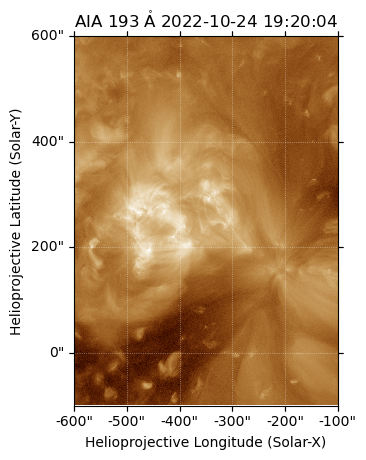

In [4]:
aia_193_map = sunpy.map.Map("../../src/AIA/20221024/193/lvl15/aia.lev1_euv_12s.2022-10-24T192003Z.193.image.fits")
aia_193_map_crop = aia_193_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_193_map.coordinate_frame), 
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_193_map.coordinate_frame))
aia_193_map_crop.plot()

In [5]:
hmi_los_map = sunpy.map.Map("../../src/HMI/20221024/lvl15/hmi.M_45s.20221024_192100_TAI.2.magnetogram.fits")
hmi_los_map_to_aia = hmi_los_map.reproject_to(aia_1600_map.wcs)

In [6]:
hmi_los_map_crop = hmi_los_map_to_aia.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=hmi_los_map_to_aia.coordinate_frame),
                                                top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=hmi_los_map_to_aia.coordinate_frame))

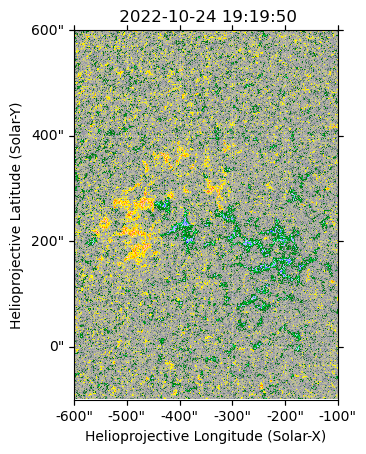

In [7]:
hmi_los_map_crop.plot(norm=ImageNormalize(vmin=-1000, vmax=1000),cmap='hmimag')

In [8]:
eis_195_velmap_derot = sunpy.map.Map("../../src/coalign_map/20221024/eis_195_velmap_derot.fits")

In [9]:
with fits.open("../../src/HMI/20221024/qmaps/hmi.q_synframe.20221024_120000_TAI.slogQ.fits") as hdul:
    hdul.info()
    hmi_qmap_data = hdul[1].data.copy()
    hmi_qmap_header = hdul[1].header.copy()

Filename: ../../src/HMI/20221024/qmaps/hmi.q_synframe.20221024_120000_TAI.slogQ.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU     54   (1441, 721, 10)   int32   


In [10]:
hmi_qmap_header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / data type of original image                    
NAXIS   =                    3 / dimension of original image                    
NAXIS1  =                 1441 / length of original image axis                  
NAXIS2  =                  721 / length of original image axis                  
NAXIS3  =                   10 / length of original image axis                  
BLANK   =          -2147483648                                                  
CHECKSUM= 'DKDoEK9nDKCnDK9n'   / HDU checksum updated 2024-03-01T17:08:52       
DATASUM = '3106136418'         / data unit checksum updated 2022-11-20T02:27:24 
CONTENT = 'Qmap of PFSS cube'  / Refer to PFSS documentation                    
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT Uniform grid in lat/

In [11]:
with fits.open("../../src/HMI/20221024/qmaps/hmi.pfss_synframe.20221024_120000_TAI.Brq.fits") as hdul:
    hdul.info()
    hmi_brq_data = hdul[1].data.copy()
    hmi_brq_header = hdul[1].header.copy()

Filename: ../../src/HMI/20221024/qmaps/hmi.pfss_synframe.20221024_120000_TAI.Brq.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU     52   (1441, 721, 10)   int32   


In [12]:
hmi_brq_header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / data type of original image                    
NAXIS   =                    3 / dimension of original image                    
NAXIS1  =                 1441 / length of original image axis                  
NAXIS2  =                  721 / length of original image axis                  
NAXIS3  =                   10 / length of original image axis                  
BLANK   =          -2147483648                                                  
CHECKSUM= '5SMaAQKR6QKXAQKX'   / HDU checksum updated 2024-03-04T16:07:11       
DATASUM = '290233570'          / data unit checksum updated 2022-11-18T01:27:19 
CONTENT = 'PFSS field cube'    / Refer to PFSS documentation                    
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT Uniform grid in lat/

In [13]:
with fits.open("../../src/HMI/20221024/qmaps/hmi.pfss_synframe.20221024_120000_TAI.Br0.fits") as hdul:
    hdul.info()
    hmi_br0_data = hdul[1].data.copy()
    hmi_br0_header = hdul[1].header.copy()

Filename: ../../src/HMI/20221024/qmaps/hmi.pfss_synframe.20221024_120000_TAI.Br0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU     51   (361, 181)   int32   


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


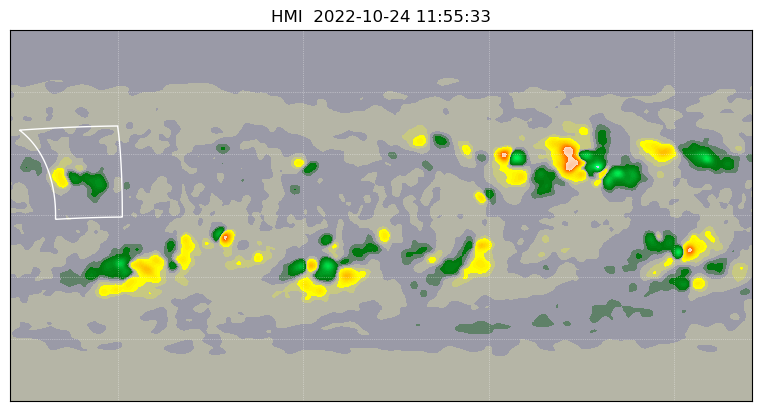

In [14]:
hmi_qmap_header_new = sunpy.map.make_fitswcs_header(data=hmi_qmap_data[0,:,:-1],
                                                    coordinate=SkyCoord(2263*360*u.deg - (hmi_qmap_header["CRVAL1"] + 720*hmi_qmap_header["CDELT1"])*u.deg,
                                                             hmi_qmap_header["CRVAL2"]*u.deg,
                                                             rsun=aia_1600_map.coordinate_frame.rsun,
                                                             frame="heliographic_carrington",
                                                             obstime=hmi_qmap_header["T_OBS"][:-8] + "_TAI"),
                                                    reference_pixel=u.Quantity([hmi_qmap_header["CRPIX1"]+720 - 1,hmi_qmap_header["CRPIX2"]-1]*u.pix),
                                                    scale=u.Quantity([-hmi_qmap_header["CDELT1"],hmi_qmap_header["CDELT2"]]*u.deg/u.pix),
                                                    projection_code="CAR",
)

hmi_1024_qmap_r1_00_map = sunpy.map.Map(hmi_qmap_data[0,:,:-1], hmi_qmap_header_new)
hmi_1024_brq_r1_00_map = sunpy.map.sources.HMISynopticMap(hmi_brq_data[0,:,:-1], hmi_qmap_header_new)
hmi_1024_qmap_r2_50_map = sunpy.map.sources.HMISynopticMap(hmi_qmap_data[-1,:,:-1], hmi_qmap_header_new)

fig = plt.figure(figsize=(8,4),layout='constrained')


ax = fig.add_subplot(111, projection=hmi_1024_brq_r1_00_map)
hmi_1024_brq_r1_00_map.plot(norm=ImageNormalize(vmin=-1000, vmax=1000),cmap='hmimag')

with propagate_with_solar_surface():
    hmi_1024_brq_r1_00_map.draw_quadrangle(aia_1600_map_crop.bottom_left_coord,top_right=aia_1600_map_crop.top_right_coord, axes=ax)

In [15]:
hmi_qmap_header_new

MetaDict([('wcsaxes': '2')
('crpix1': '721.0')
('crpix2': '361.0')
('cdelt1': '0.25')
('cdelt2': '0.25')
('cunit1': 'deg')
('cunit2': 'deg')
('ctype1': 'CRLN-CAR')
('ctype2': 'CRLT-CAR')
('crval1': '307.8000030517578')
('crval2': '0.0')
('lonpole': '0.0')
('latpole': '90.0')
('mjdref': '0.0')
('date-obs': '2022-10-24T11:55:33.000')
('rsun_ref': '696000000.0')
('naxis': '2')
('naxis1': '1440')
('naxis2': '721')
('pc1_1': '1.0')
('pc1_2': '-0.0')
('pc2_1': '0.0')
('pc2_2': '1.0')])

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


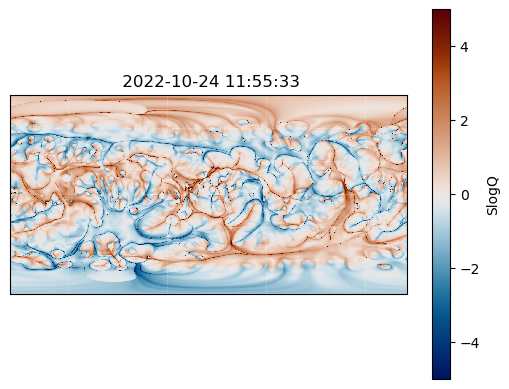

In [16]:
hmi_1024_qmap_r1_00_map.plot(norm=ImageNormalize(vmin=-5,vmax=5),cmap=cmcm.vik)
plt.colorbar(label="SlogQ")

In [17]:
hmi_synoptic_map = sunpy.map.Map("../../src/HMI/CR2263/hmi.Synoptic_Mr_720s.2263.synopMr.fits")

In [18]:
hmi_synoptic_map_double = sunpy.map.Map(hmi_synoptic_map.data,hmi_synoptic_map.wcs)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


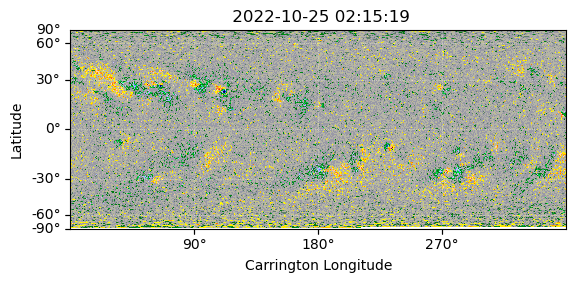

In [19]:
hmi_synoptic_map_double.plot(norm=ImageNormalize(vmin=-1000, vmax=1000),cmap='hmimag')

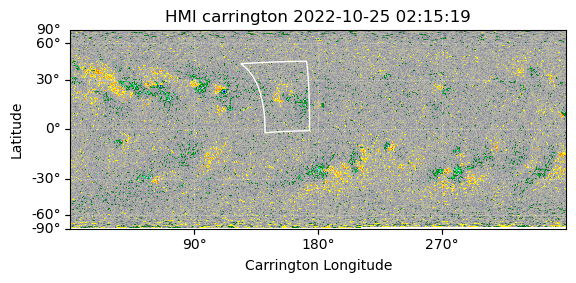

In [20]:
hmi_synoptic_map.plot()
with propagate_with_solar_surface():
    hmi_synoptic_map.draw_quadrangle(aia_1600_map_crop.bottom_left_coord,top_right=aia_1600_map_crop.top_right_coord)


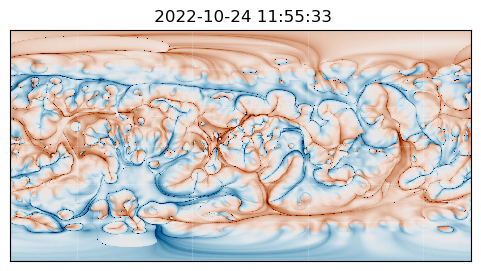

In [21]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111, projection=hmi_1024_qmap_r1_00_map)
hmi_1024_qmap_r1_00_map.plot(norm=ImageNormalize(vmin=-5,vmax=5),cmap=cmcm.vik,axes=ax)

In [22]:
with propagate_with_solar_surface():
    hmi_1024_qmap_r1_00_map_to_aia_crop = hmi_1024_qmap_r1_00_map.reproject_to(aia_1600_map_crop.wcs)

(-0.5, 834.5, -0.5, 1167.5)

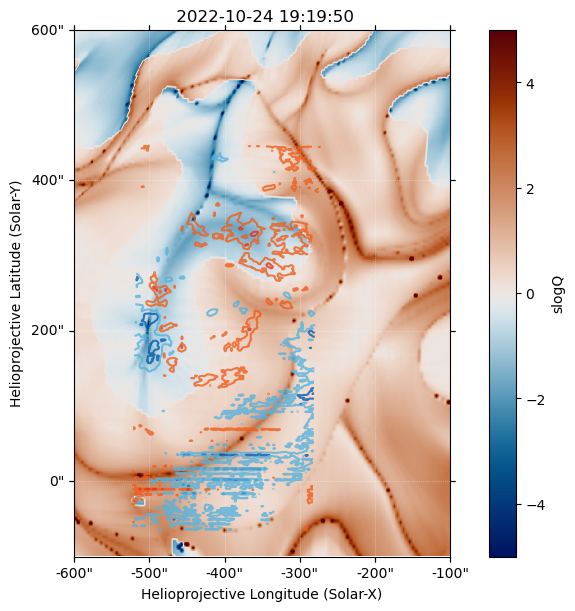

In [23]:
fig = plt.figure(figsize=(6,6),layout="constrained")
ax = fig.add_subplot(111, projection=hmi_1024_qmap_r1_00_map_to_aia_crop)
hmi_1024_qmap_r1_00_map_to_aia_crop.plot(norm=ImageNormalize(vmin=-5,vmax=5),cmap=cmcm.vik,axes=ax)
plt.colorbar(label="slogQ")

bounds = ax.axis()
eis_195_velmap_derot.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                                axes=ax)
ax.axis(bounds)

In [24]:
with propagate_with_solar_surface():
    hmi_synoptic_map_to_aia_crop = hmi_synoptic_map.reproject_to(aia_1600_map_crop.wcs)
    hmi_1024_brq_r1_00_map_to_aia_crop = hmi_1024_brq_r1_00_map.reproject_to(aia_1600_map_crop.wcs)
    

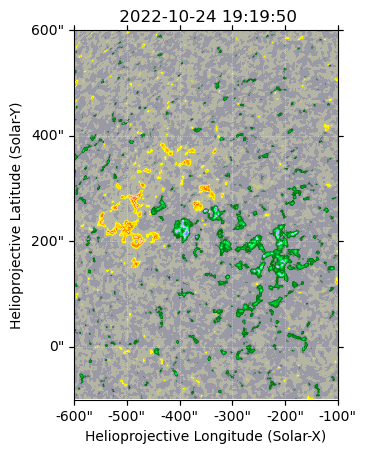

In [25]:
hmi_synoptic_map_to_aia_crop.plot()

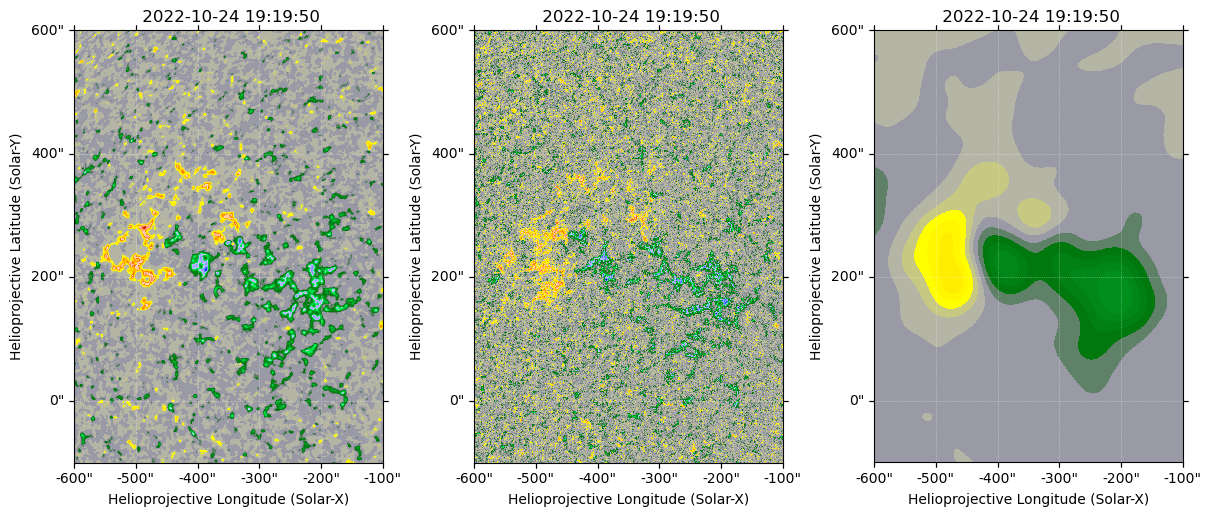

In [26]:
fig = plt.figure(figsize=(12,6),layout="constrained")

ax = fig.add_subplot(131, projection=hmi_synoptic_map_to_aia_crop)
hmi_synoptic_map_to_aia_crop.plot(axes=ax,norm=ImageNormalize(vmin=-1000,vmax=1000),cmap="hmimag")

ax = fig.add_subplot(132, projection=hmi_los_map_crop)
hmi_los_map_crop.plot(axes=ax,norm=ImageNormalize(vmin=-1000,vmax=1000),cmap="hmimag")

ax = fig.add_subplot(133, projection=hmi_1024_brq_r1_00_map_to_aia_crop)
hmi_1024_brq_r1_00_map_to_aia_crop.plot(axes=ax,norm=ImageNormalize(vmin=-1000,vmax=1000),cmap="hmimag")

In [27]:
eis_195_velmap_20221020 = sunpy.map.Map("../../src/coalign_map/20221020/eis_195_velmap_shift.fits")

with propagate_with_solar_surface(rotation_model="rigid"):
    eis_195_velmap_20221020_to_aia_crop = eis_195_velmap_20221020.reproject_to(aia_1600_map_crop.wcs)

(-0.5, 834.5, -0.5, 1167.5)

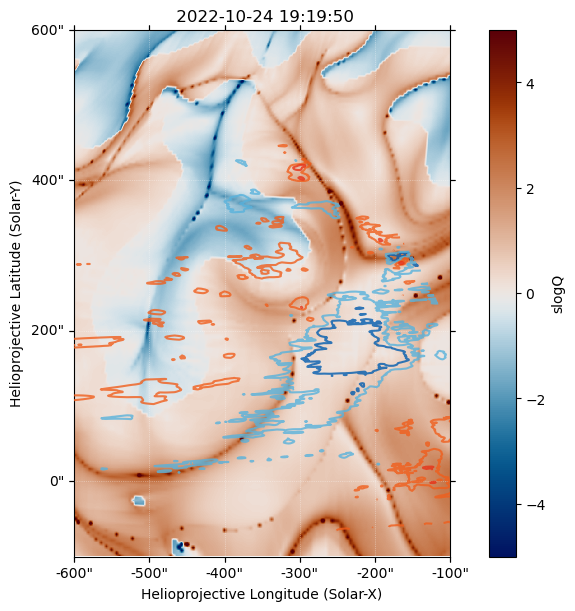

In [28]:
fig = plt.figure(figsize=(6,6),layout="constrained")
ax = fig.add_subplot(111, projection=hmi_1024_qmap_r1_00_map_to_aia_crop)
hmi_1024_qmap_r1_00_map_to_aia_crop.plot(norm=ImageNormalize(vmin=-5,vmax=5),cmap=cmcm.vik,axes=ax)
plt.colorbar(label="slogQ")

bounds = ax.axis()
eis_195_velmap_20221020_to_aia_crop.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                                axes=ax)
ax.axis(bounds)